In [1]:
%matplotlib widget
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import spatial, stats
import matplotlib.pyplot as plt
import pytest
import ipytest
ipytest.autoconfig(raise_on_error=True)

In [2]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1-point2)

In [3]:
random_points = stats.uniform.rvs(0, 100, (100,3))
print(random_points)
N = random_points.shape[0]


[[9.72005822e+01 5.73436542e+01 6.09822662e+01]
 [2.09342950e+01 2.85686598e+01 6.09825510e+01]
 [7.30492529e+01 5.19741148e+01 2.74504480e+00]
 [4.91935594e+01 4.28072252e+01 2.19406249e+01]
 [4.46539352e+01 8.57308204e+01 6.46385673e+01]
 [3.31498163e+01 7.92578035e+01 7.16855407e+01]
 [9.88808092e+01 5.31075539e+01 2.65997968e+01]
 [7.24590557e+01 9.44743450e+01 6.94124958e+00]
 [1.22913596e+01 2.41864465e+01 9.40688102e+01]
 [7.27602594e+01 7.97253252e+01 8.57033502e+01]
 [7.44730666e+01 9.27369875e+01 1.01597505e+01]
 [6.48992246e+01 2.65248750e+01 6.58379421e+01]
 [8.39157335e+01 7.97640144e+01 6.11358658e+01]
 [8.98072601e+00 7.47192220e+01 9.02530089e+01]
 [9.27479712e+01 1.56380941e+01 3.03987303e+00]
 [3.26808514e+01 1.98236936e+01 7.87017774e+01]
 [4.98235547e+01 7.17821271e+01 9.74838660e+01]
 [7.17361141e+01 9.82526938e+00 9.65808619e-01]
 [1.10312573e+01 4.46249656e+00 4.82160513e+01]
 [1.50121864e+01 3.49670120e+01 9.11970974e+01]
 [3.40575099e+01 6.92782696e+01 9.241998

In [4]:
# Test distance function
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


In [5]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

In [6]:
x_min = 0; x_max = 100
y_min = 0; y_max = 100
z_min = 0; z_max = 100
total_volume = (x_max - x_min)*(y_max - y_min)*(z_max - z_min)

In [7]:
# Currently using x_max-x_min as maximum radius, by convention it should be sqrt(x_max-x_min/2)
radii = np.linspace(0,x_max-x_min,50).reshape(50,1)

In [8]:
tree = spatial.cKDTree(random_points)
idx_in = tree.query_ball_point((50,50,50),20)

idx_out = np.ones(len(random_points), bool)
idx_out[idx_in] = 0

pts_inside_radius = random_points[idx_in]
pts_outside_radius = random_points[idx_out]

print(len(random_points), len(pts_inside_radius), len(pts_outside_radius))

100 7 93


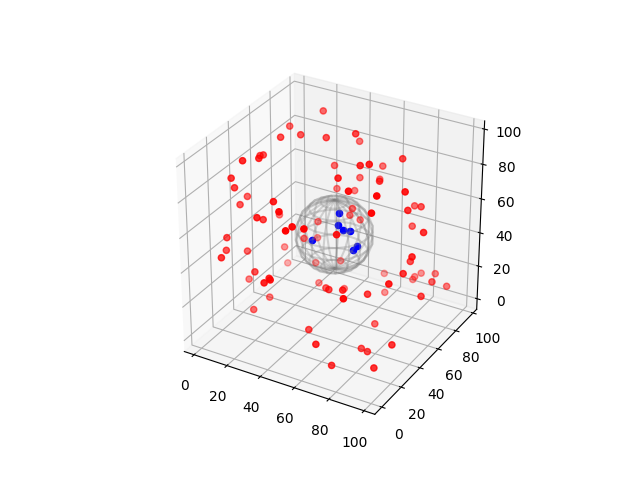

In [9]:
ix, ox = pts_inside_radius[:, 0], pts_outside_radius[:, 0]
iy, oy = pts_inside_radius[:, 1], pts_outside_radius[:, 1]
iz, oz = pts_inside_radius[:, 2], pts_outside_radius[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
ax.scatter(ix,iy,iz, color="b",marker="o", depthshade=0)
ax.scatter(ox,oy,oz,color="r",marker="o", depthshade=1)


scale = 20
# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
cx = scale*np.cos(u)*np.sin(v)+50
cy = scale*np.sin(u)*np.sin(v)+50
cz = scale*np.cos(v)+50
ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)


In [10]:
# For this rectangular test case
volume = 100*100*100

Ripley's K Estimators

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BK%7D%28r%29%3D%20%5Cfrac%7BV%7D%7BN%28N-1%29%7D%20%5Csum_i%5EN%20%5Csum_%7Bj%20%5Cneq%20i%7D%5EN%20%20%5Cfrac%7BI%28d_%7Bi%2Cj%7D%3Cr%29%7D%7B%5Comega_%7Bi%2Cj%7D%7D%20%20%20%20%20&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BL%7D%28r%29%3D%20%20%20%5Csqrt%5B3%5D%7B%5Cfrac%7B3%20%20%5Cwidehat%7BK%7D%28r%29%7D%7B4%5Cpi%7D%7D&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BH%7D%28r%29%3D%5Cwidehat%7BL%7D%28r%29-r&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=0)

In [11]:
def ripley(points: np.ndarray, radii: list) -> tuple:
    """
    Calculate RipleyK spatial statistic on 3D point cloud

    args:
        points (numpy.ndarray): shape (N, 3), where N is the number of points
        radii (list[int]): list of radii to compute
        intensity (float): lambda, number of points / total volume (N/V)

    """
    ### Function starts with input checks

    # Check if points is a list or numpy array
    if not isinstance(points, (list, np.ndarray)):
        e = f"Expected {np.ndarray}, received {type(points)}"
        raise ValueError(e)

    # Convert points to numpy array if it is a list
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    # Check if points array has two dimensions
    if len(points.shape) != 2:
        e = f"Expected points array to have 2 dimensions, but got array with shape {points.shape}"
        raise ValueError(e)

    # Check if the points array second dimension length is 3 (x, y, z)
    if points.shape[1] != 3:
        e = f"Expected points array to have shape (None, 3), but got array with shape {points.shape}"
        raise ValueError(e)

    # Check if radii is list-like or number-like
    if not isinstance(radii, (np.ndarray, list, int, float)):
        e = f"Expected {(np.ndarray, list, int, float)}, received {type(radii)}"
        raise ValueError(e)

    # if only one radius given as int, convert to list
    if not isinstance(radii, (np.ndarray, list)):
        radii = [radii]

    ### Compute Ripley's K Statistic 

    results = {"K": [], "L": [], "H": []}

    # Loop through each radius
    for radius in radii:
        # For each radius, loop through each point and count neighbors
        # within the radius
        nb_count = 0
        for x, y, z in points:
            # query_ball_point() includes the index of the current point as well
            # so 1 is subtracted from the count
            nb_count += len(tree.query_ball_point([x, y, z], radius)) - 1

        # calculating Ripley's functions (K, L, H)
        K = nb_count * volume / (N * (N - 1))
        L = ((3 / 4) * (K / np.pi)) ** (1 / 3)
        H = L - radius

        results["K"].append(K)
        results["L"].append(L)
        results["H"].append(H)
    
    return results["K"], results["L"], results["H"]




In [12]:
radii = np.arange(0, 50)

In [13]:
K, L, H = ripley(random_points, radii)

rstats = pd.DataFrame([radii, K, L, H], index=["Radius (r)", "K(r)", "L(r)", "H(r)"]).T


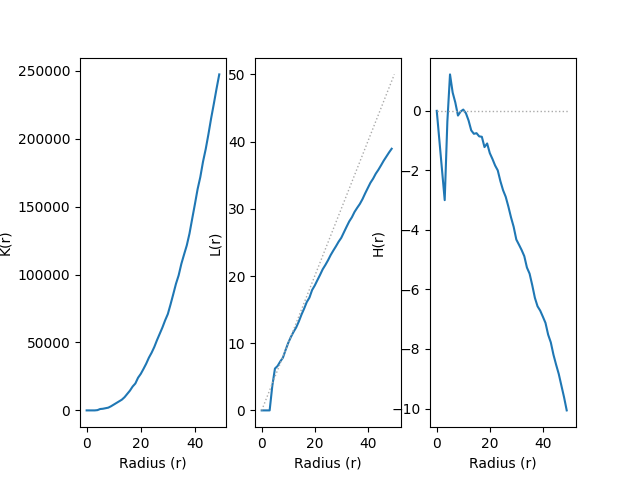

In [14]:
f, axes = plt.subplots(1, 3,)

sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0])

sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1])
axes[1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa")

sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[2])
axes[2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa")

plt.show()

In [15]:
%%ipytest

# Tests
def test_valid_input():
    valid_points = [
        np.array([[38.4002419, 38.62931512, 41.6131775]]),
        np.array([[38, 38, 41],[1, 2, 3]]),
        [[38.4002419, 38.62931512, 41.6131775]],
        [[38, 38, 41], [1, 2, 3]],
    ]
    for p in valid_points:
        ripley(p, radii=1)

def test_invalid_input():
    invalid_points = [
        "38.4002419, 38.62931512, 41.6131775",
        np.array([38.4002419, 38.62931512, 41.6131775]),
        np.array([[[38.4002419, 38.62931512, 41.6131775]]]),
        np.array([[38.4002419, 38.62931512]]),
        5,
        7.8,
        [6],
    ]
    for p in invalid_points:
        with pytest.raises(ValueError):
            ripley(p, radii=1)


..                                                                                           [100%]
2 passed in 0.01s


In [16]:
def calculate_ripley(radii, sample_size, d1=None, d2=None, d3=None, sample_shape='circle', boundary_correct=False, CSR_Normalise=False):
    results = []
    tree, dimensions = make_tree(d1=d1, d2=d2, d3=d3)
    if type(radii) is not list:
        radii = [radii]
    for radius in radii:
        
        score_vol = (4/3) * np.pi * radius**3
        
        if sample_shape=='circle':
            bound_size = (4/3) * np.pi * sample_size ** 3
        elif sample_shape=='rectangle':
            bound_size = sample_size[0]*sample_size[1]*sample_size[2]
        counts = 0
        for x, y, z in zip(d1, d2, d3):
            if boundary_correct:
                vol = calculate_overlap([x,y,z], sample_size, radius, sample_shape, dimensions)
                boundary_correction = vol/score_vol
                counts += (len(tree.query_ball_point([x,y,z], radius))-1)/boundary_correction
            else:
                counts += len(tree.query_ball_point([x,y,z], radius))-1
                    
        if CSR_Normalise:
            results.append((bound_size*counts/len(d1)**2) - score_vol)
        else:
            results.append(bound_size*counts/len(d1)**2)
    if len(results)==1:
        return results[0]
    else:
        return results